# Run the DNN model

First, we have to create the PyTorch objects out of the NPZ files. NPZ files behave like dictionaries of arrays. In our case, they contain two keys:

- `X`: the featurized systems
- `y`: the associated measurements

We can pass those dict-like arrays to an adapter class for Torch Datasets, which will be ingested by the DataLoaders. We also need the corresponding observation models.

In [10]:
from pathlib import Path
from collections import defaultdict
import numpy as np

import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from kinoml.core import measurements as measurement_types
from kinoml.datasets.torch_datasets import XyNpzTorchDataset

HERE = Path(_dh[-1])

In [2]:
datasets = defaultdict(dict)
for npz in HERE.glob("../_output/ChEMBL__*.npz"):
    _, kinase, measurement_type = str(npz.stem).split("__")
    datasets[kinase][measurement_type] = XyNpzTorchDataset(npz)

In [3]:
obs_models = {k: getattr(measurement_types, k).observation_model(backend="pytorch") for k in ["pKiMeasurement", "pIC50Measurement", "pKdMeasurement"]}
obs_models

{'pKiMeasurement': <function kinoml.core.measurements.pKiMeasurement._observation_model_pytorch(dG_over_KT, standard_conc=1, **kwargs)>,
 'pIC50Measurement': <function kinoml.core.measurements.pIC50Measurement._observation_model_pytorch(dG_over_KT, substrate_conc=1e-06, michaelis_constant=1, standard_conc=1, **kwargs)>,
 'pKdMeasurement': <function kinoml.core.measurements.pKdMeasurement._observation_model_pytorch(dG_over_KT, standard_conc=1, **kwargs)>}

Now that we have all the data-dependent objects, we can start with the model-specific definitions.

In [5]:
one_kinase = "P35968"
train_dataloaders, test_dataloaders = {}, {}
for mtype in ["pKiMeasurement", "pIC50Measurement", "pKdMeasurement"]:
    train_dataloaders[mtype], test_dataloaders[mtype] = datasets[one_kinase][mtype].as_dataloader(train_test_split=0.8, shuffle=False, batch_size=64)

In [8]:
from kinoml.ml.torch_models import NeuralNetworkRegression
from tqdm.auto import trange

In [11]:
input_size = train_dataloaders["pIC50Measurement"].dataset.input_size()
model = NeuralNetworkRegression(input_size=input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_function = torch.nn.MSELoss() # Mean squared error

nb_epoch = 100
loss_timeseries = []
ys = []
range_epochs = trange(nb_epoch, desc="Epochs")
for epoch in range_epochs:
    # Single cumulative loss / or loss per loader? look into this!
    cumulative_loss = 0.0
    ys.append([])
    for i, (measurement_type, loader) in enumerate(train_dataloaders.items()):
        obs_model = obs_models[measurement_type]
        for j, (x, y) in enumerate(loader):

            # Clear gradients
            optimizer.zero_grad()

            # Obtain model prediction given model input
            delta_g = model(x)

            # with observation model
            prediction = obs_model(delta_g)
            
            # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            # !!! Make sure prediction and y match shapes !!!
            # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            
            y = y.reshape(prediction.shape)

            ys[-1].append((delta_g, prediction, y))

            # prediction = delta_g
            loss = loss_function(prediction, y)

            # Obtain loss for the predicted output
            # if cumulative loss is global, change this i to 0, or viceversa
            cumulative_loss += loss.item()

            # Gradients w.r.t. parameters
            loss.backward()

            # Optimizer
            optimizer.step()
            if j % 1000 == 0:
                range_epochs.set_description(f"Epochs (loss={cumulative_loss / 1000:.2e})")
                cumulative_loss = 0.0
            
    loss_timeseries.append(cumulative_loss)

Save model to disk!

In [60]:
output = HERE / "_output/"
output.mkdir(parents=True, exist_ok=True)
torch.save(model, output / "model.pt")

## Analysis

Loss  timeseries

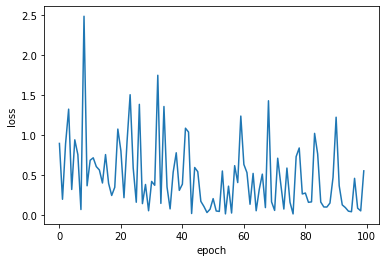

In [40]:
%matplotlib inline
from matplotlib import pyplot as plt

f = plt.figure()
plt.plot(loss_timeseries)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Measure performance against all data

In [63]:
from kinoml.analysis.plots import predicted_vs_true
from kinoml.analysis.metrics import performance

pKiMeasurement train
--------------------
R2: 0.89
MSE: 0.25
MAE: 0.29
RMSE: 0.50


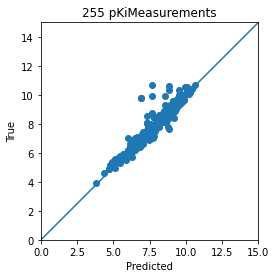

pKiMeasurement test
-------------------
R2: 0.46
MSE: 1.01
MAE: 0.74
RMSE: 1.00


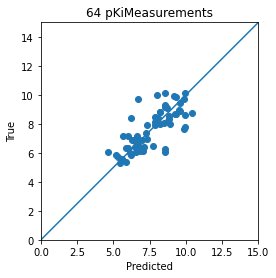


****************
pIC50Measurement train
----------------------
R2: 0.87
MSE: 0.17
MAE: 0.27
RMSE: 0.41


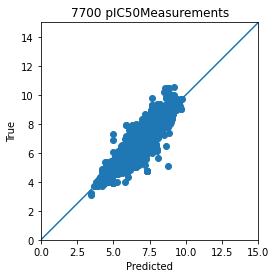

pIC50Measurement test
---------------------
R2: 0.48
MSE: 0.64
MAE: 0.59
RMSE: 0.80


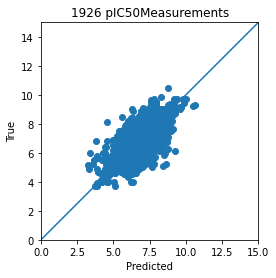


****************
pKdMeasurement train
--------------------
R2: 0.73
MSE: 0.38
MAE: 0.37
RMSE: 0.62


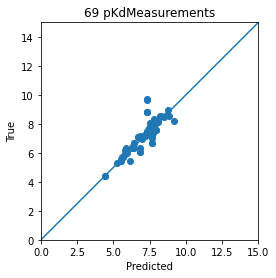

pKdMeasurement test
-------------------
R2: 0.41
MSE: 0.58
MAE: 0.64
RMSE: 0.76


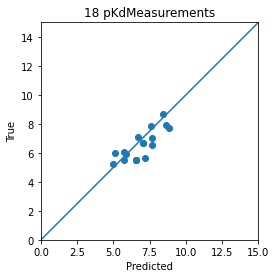


****************


In [59]:
for mtype in ["pKiMeasurement", "pIC50Measurement", "pKdMeasurement"]:
    for ttype, dataloaders in {"train": train_dataloaders, "test": test_dataloaders}.items():
        true = dataloaders[mtype].dataset.data_y[dataloaders[mtype].sampler.indices]
        model_input = dataloaders[mtype].dataset.data_X[dataloaders[mtype].sampler.indices]

        delta_g = model(model_input)
        prediction = obs_models[mtype](delta_g).detach().numpy()

        print(mtype, ttype)
        print("-"*(len(mtype)+len(ttype)+1))
        display(predicted_vs_true(prediction, true, limits=(0, 15), title=f"{prediction.shape[0]} {mtype}s"))
    print("\n****************")